# Class-Aware OOD with CIFAR-100
This walkthrough configures MetaLoRA for class-aware sampling on CIFAR-100 and evaluates out-of-distribution robustness.

- Configure paths, dependencies, and experiment settings.
3- Train on all CIFAR-100 classes with a class-aware sampler.
- Use SVHN as a truly OOD benchmark while reusing the CIFAR-trained head.
- Report both in-distribution accuracy and SVHN OOD metrics.

In [3]:
import os
import random
import subprocess
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from omegaconf import OmegaConf
from sklearn.metrics import average_precision_score, roc_auc_score
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR100 as TorchvisionCIFAR100, SVHN as TorchvisionSVHN


def find_repo_root(start: Path, marker: str = "main.py", max_depth: int = 10) -> Path:
    """Locate the repository root when running locally or inside Colab."""
    env_root = os.environ.get("METALORA_ROOT") or os.environ.get("REPO_ROOT")
    if env_root:
        candidate = Path(env_root).expanduser().resolve()
        if (candidate / marker).exists():
            return candidate
    current = start.resolve()
    for _ in range(max_depth):
        if (current / marker).exists():
            return current
        if current.parent == current:
            break
        current = current.parent
    colab_candidate = Path("/content/metalora").resolve()
    if (colab_candidate / marker).exists():
        return colab_candidate
    if Path("/content").exists():
        print("Repository not found; attempting to clone into /content/metalora ...")
        subprocess.run(
            [
                "git",
                "clone",
                "https://github.com/doem97/metalora.git",
                str(colab_candidate),
            ],
            check=True,
        )
        if (colab_candidate / marker).exists():
            return colab_candidate
    raise FileNotFoundError(
        f"Could not locate {marker}. Set METALORA_ROOT to the repo path or clone it under /content/metalora."
    )


REPO_ROOT = find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
if "datasets" in sys.modules:
    del sys.modules["datasets"]
os.chdir(REPO_ROOT)

import datasets
from trainer import (
    CLASS_MEAN_FNAME,
    TEXT_FEAT_FNAME,
    Trainer,
    load_clip_to_cpu,
    load_vit_to_cpu,
    )
from models import PeftModelFromCLIP, PeftModelFromViT, ZeroShotCLIP
from models.satmae_vit import MAEViTAdapter
from utils.config_omega import cfg as base_cfg
from utils.evaluator import Evaluator
from utils.logger import logger
from utils.samplers import ClassAwareSampler, DownSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
def load_experiment_config(repo_root, dataset_name, model_name, tuner_name=None, overrides=None):
    config = OmegaConf.create(OmegaConf.to_container(base_cfg, resolve=True))
    config_paths = [
        repo_root / "configs" / "data" / f"{dataset_name}.yaml",
        repo_root / "configs" / "model" / f"{model_name}.yaml",
    ]
    if tuner_name:
        config_paths.append(repo_root / "configs" / "tuner" / f"{tuner_name}.yaml")
    for path in config_paths:
        if not path.exists():
            raise FileNotFoundError(path)
        config = OmegaConf.merge(config, OmegaConf.load(path))
    if overrides:
        config = OmegaConf.merge(config, OmegaConf.create(overrides))
    return config


def make_cifar_subset(dataset_cls, root, train, transform, class_indices, remap=True):
    keep = sorted(class_indices)
    dataset = dataset_cls(root, train=train, transform=transform)
    targets = list(dataset.targets)
    indices = [idx for idx, label in enumerate(targets) if label in keep]
    if len(indices) == 0:
        raise ValueError("No samples found for the provided classes.")
    index_array = np.array(indices, dtype=np.int64)
    dataset.data = dataset.data[index_array]
    selected_targets = [targets[idx] for idx in indices]
    dataset.original_targets = selected_targets.copy()
    subset_classnames = [dataset.classes[idx] for idx in keep]
    if remap:
        label_map = {orig: new_idx for new_idx, orig in enumerate(keep)}
        remapped_targets = [label_map[label] for label in selected_targets]
        dataset.targets = remapped_targets
        dataset.labels = remapped_targets
        dataset.classes = subset_classnames
        dataset.classnames = subset_classnames
        dataset.class_to_idx = {name: idx for idx, name in enumerate(subset_classnames)}
        dataset.label_map = label_map
        dataset.inverse_label_map = {v: k for k, v in label_map.items()}
    else:
        dataset.targets = selected_targets
        dataset.labels = selected_targets
        dataset.classnames = subset_classnames
        dataset.label_map = None
        dataset.inverse_label_map = None
    if hasattr(dataset, "get_cls_num_list"):
        dataset.cls_num_list = dataset.get_cls_num_list()
        dataset.num_classes = len(dataset.cls_num_list)
    else:
        dataset.num_classes = len(subset_classnames)
        dataset.cls_num_list = [dataset.targets.count(i) for i in range(dataset.num_classes)]
    dataset.keep_classes = keep
    return dataset


def compute_ood_metrics(id_scores, ood_scores, tpr=0.95):
    id_scores = np.asarray(id_scores, dtype=np.float32)
    ood_scores = np.asarray(ood_scores, dtype=np.float32)
    if id_scores.size == 0 or ood_scores.size == 0:
        raise ValueError("Need non-empty ID and OOD score arrays.")
    labels = np.concatenate([np.ones_like(id_scores), np.zeros_like(ood_scores)])
    scores = np.concatenate([id_scores, ood_scores])
    threshold = np.percentile(id_scores, (1.0 - tpr) * 100.0)
    metrics = {
        "auroc": float(roc_auc_score(labels, scores)),
        "aupr": float(average_precision_score(labels, scores)),
        "fpr@95tpr": float(np.mean(ood_scores >= threshold)),
        "threshold@95tpr": float(threshold),
        "id_mean": float(id_scores.mean()),
        "id_std": float(id_scores.std()),
        "ood_mean": float(ood_scores.mean()),
        "ood_std": float(ood_scores.std()),
    }
    return metrics

In [5]:
class ClassAwareOODTrainer(Trainer):
    def __init__(self, cfg, device, id_classes, ood_classes=None, class_aware_k=4):
        self.id_classes = sorted(set(id_classes))
        self.ood_classes = sorted(set(ood_classes or []))
        self.external_ood_name = getattr(cfg, "ood_dataset", None)
        self.external_ood_name = (
            self.external_ood_name.lower() if self.external_ood_name else None
        )
        overlap = set(self.id_classes) & set(self.ood_classes)
        if overlap and not self.external_ood_name:
            raise ValueError(
                f"In-distribution and OOD classes overlap: {sorted(overlap)}"
            )
        self.class_aware_k = class_aware_k
        self.use_class_aware_sampler = class_aware_k is not None and class_aware_k > 0
        self.training_history = []
        super().__init__(cfg, device)
        self.local_rank = 0
        self.world_size = 1
        self.ood_test_loader = None
        root_hint = Path(cfg.root or os.environ.get("CIFAR100_ROOT", "./data")).expanduser()
        class_names = getattr(TorchvisionCIFAR100, "classes", None)
        if class_names is None:
            preview_dataset = TorchvisionCIFAR100(
                root=str(root_hint), train=True, download=True
            )
            class_names = preview_dataset.classes
        self.global_classnames = class_names
        self.id_classnames = [class_names[idx] for idx in self.id_classes]
        if self.external_ood_name:
            self.ood_classnames = None
        else:
            self.ood_classnames = [class_names[idx] for idx in self.ood_classes]
        self.last_ood_scores = None

    def build_data_loader(self):
        cfg = self.cfg
        root = cfg.root
        resolution = cfg.resolution

        if cfg.backbone.startswith("CLIP"):
            mean = [0.48145466, 0.4578275, 0.40821073]
            std = [0.26862954, 0.26130258, 0.27577711]
        else:
            mean = [0.5, 0.5, 0.5]
            std = [0.5, 0.5, 0.5]

        transform_train = transforms.Compose(
            [
                transforms.RandomResizedCrop(resolution),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
)

        transform_plain = transforms.Compose(
            [
                transforms.Resize(resolution),
                transforms.CenterCrop(resolution),
                transforms.ToTensor(),
                transforms.Normalize(mean, std),
            ]
)

        transform_test = transforms.Compose(
            [
                transforms.Resize(resolution * 8 // 7),
                transforms.CenterCrop(resolution),
                transforms.Lambda(
                    lambda crop: torch.stack([transforms.ToTensor()(crop)])
                ),
                transforms.Normalize(mean, std),
            ]
)

        dataset_cls = getattr(datasets, cfg.dataset)
        train_dataset = make_cifar_subset(
            dataset_cls, root, True, transform_train, self.id_classes, remap=True
        )
        train_init_dataset = make_cifar_subset(
            dataset_cls, root, True, transform_plain, self.id_classes, remap=True
        )
        train_test_dataset = make_cifar_subset(
            dataset_cls, root, True, transform_test, self.id_classes, remap=True
        )
        id_test_dataset = make_cifar_subset(
            dataset_cls, root, False, transform_test, self.id_classes, remap=True
        )

        if self.external_ood_name:
            ood_test_dataset = self._build_external_ood_dataset(transform_test)
        else:
            if not self.ood_classes:
                raise ValueError(
                    "No OOD classes specified and external OOD dataset not provided."
                )
            ood_test_dataset = make_cifar_subset(
                dataset_cls, root, False, transform_test, self.ood_classes, remap=False
            )

        self.num_classes = train_dataset.num_classes
        self.cls_num_list = train_dataset.cls_num_list
        self.classnames = train_dataset.classnames

        freq = np.array(self.cls_num_list)
        self.many_idxs = np.where(freq > 100)[0]
        self.med_idxs = np.where((freq >= 20) & (freq <= 100))[0]
        self.few_idxs = np.where(freq < 20)[0]

        if cfg.init_head == "1_shot":
            init_sampler = DownSampler(train_init_dataset, n_max=1)
        elif cfg.init_head == "10_shot":
            init_sampler = DownSampler(train_init_dataset, n_max=10)
        elif cfg.init_head == "100_shot":
            init_sampler = DownSampler(train_init_dataset, n_max=100)
        else:
            init_sampler = None

        self.accum_step = cfg.accum_step or 1
        self.eff_batch_size = cfg.batch_size
        denom = self.accum_step * self.world_size
        if self.eff_batch_size % denom != 0:
            raise ValueError(
                f"batch_size ({cfg.batch_size}) must be divisible by accum_step ({self.accum_step})."
            )
        self.per_gpu_batch_size = self.eff_batch_size // denom

        if self.use_class_aware_sampler:
            train_sampler = ClassAwareSampler(
                train_dataset, num_samples_cls=self.class_aware_k
            )
            shuffle_train = False
        else:
            train_sampler = None
            shuffle_train = True
        sampler_desc = (
            "class-aware sampler" if train_sampler else "standard shuffled batches"
        )
        print(f"Train sampler: {sampler_desc}")

        pin = self.device.type == "cuda"
        self.train_loader = DataLoader(
            train_dataset,
            batch_size=self.per_gpu_batch_size,
            sampler=train_sampler,
            shuffle=shuffle_train,
            num_workers=cfg.num_workers,
            pin_memory=pin,
        )

        self.train_init_loader = DataLoader(
            train_init_dataset,
            batch_size=min(64, len(train_init_dataset)),
            sampler=init_sampler,
            shuffle=init_sampler is None,
            num_workers=cfg.num_workers,
            pin_memory=pin,
        )

        self.train_test_loader = DataLoader(
            train_test_dataset,
            batch_size=64,
            shuffle=False,
            num_workers=cfg.num_workers,
            pin_memory=pin,
        )

        self.test_loader = DataLoader(
            id_test_dataset,
            batch_size=64,
            shuffle=False,
            num_workers=cfg.num_workers,
            pin_memory=pin,
        )

        self.ood_test_loader = DataLoader(
            ood_test_dataset,
            batch_size=64,
            shuffle=False,
            num_workers=cfg.num_workers,
            pin_memory=pin,
        )

        ood_desc = (
            f"OOD dataset ({self.external_ood_name.upper()}): {len(ood_test_dataset)} samples"
            if self.external_ood_name
            else f"OOD samples: {len(ood_test_dataset)}"
        )
        print(
            f"Train samples: {len(train_dataset)} | ID classes: {len(self.id_classes)} | {ood_desc}"
        )

    def build_model(self):
        cfg = self.cfg
        classnames = self.classnames
        num_classes = len(classnames)

        if cfg.backbone.startswith("CLIP"):
            clip_model = load_clip_to_cpu(cfg.backbone, cfg.prec)
            if cfg.zero_shot:
                self.model = ZeroShotCLIP(clip_model)
                self.model.to(self.device)
                self.tuner = None
                self.head = None
                template = "a photo of a {}."
                prompts = self.get_tokenized_prompts(classnames, template)
                self.model.init_text_features(prompts)
                return
            self.model = PeftModelFromCLIP(cfg, clip_model, num_classes)
        elif cfg.backbone.startswith("IN21K-ViT"):
            vit_model = load_vit_to_cpu(cfg.backbone, cfg.prec)
            self.model = PeftModelFromViT(cfg, vit_model, num_classes)
        elif cfg.backbone.startswith("SatMAE-ViT"):
            vit_model = load_vit_to_cpu(cfg.backbone, cfg.prec)
            self.model = PeftModelFromViT(cfg, vit_model, num_classes)
        else:
            raise ValueError(f"Unsupported backbone: {cfg.backbone}")

        self.model.to(self.device)
        self.tuner = getattr(self.model, "tuner", None)
        self.head = getattr(self.model, "head", None)

        if cfg.init_head == "text_feat":
            if not cfg.backbone.startswith("CLIP"):
                print("text_feat head init is only available for CLIP backbones.")
            else:
                text_feat_fname = TEXT_FEAT_FNAME.get(cfg.backbone)
                if text_feat_fname is None:
                    raise ValueError(
                        f"No text feature file registered for {cfg.backbone}"
                    )
                if cfg.head_init_folder is None:
                    raise ValueError(
                        "head_init_folder must be set for text feature initialization."
                    )
                text_feat_path = os.path.join(cfg.head_init_folder, text_feat_fname)
                self.init_head_text_feat(text_feat_path)
        elif cfg.init_head in ["class_mean", "1_shot", "10_shot", "100_shot"]:
            class_mean_fname = CLASS_MEAN_FNAME.get(cfg.backbone)
            if class_mean_fname is None:
                raise ValueError(
                    f"No class mean file registered for {cfg.backbone}"
                )
            if cfg.head_init_folder is None:
                raise ValueError(
                    "head_init_folder must be set for class mean initialization."
                )
            class_mean_path = os.path.join(cfg.head_init_folder, class_mean_fname)
            self.init_head_class_mean(class_mean_path)
        elif cfg.init_head == "linear_probe":
            self.init_head_linear_probe()

        if not (cfg.zero_shot or cfg.test_train or cfg.test_only):
            self.build_optimizer()
            self.build_criterion()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    def _build_external_ood_dataset(self, transform):
        dataset_name = self.external_ood_name
        if dataset_name == "svhn":
            root = getattr(self.cfg, "ood_root", None)
            if root is None:
                root = Path(self.cfg.root).expanduser() / "svhn"
            root = Path(root).expanduser()
            split = getattr(self.cfg, "ood_split", "test")
            return TorchvisionSVHN(
                root=str(root),
                split=split,
                download=True,
                transform=transform,
            )
        raise ValueError(
            f"Unsupported external OOD dataset: {self.external_ood_name}"
        )

    @torch.no_grad()
    def evaluate_ood(self):
        if self.ood_test_loader is None:
            raise RuntimeError("OOD loader not initialized.")
        self.model.eval()
        if self.tuner is not None:
            self.tuner.eval()
        if self.head is not None:
            self.head.eval()

        amp_enabled = self.cfg.prec == "amp" and self.device.type == "cuda"

        def collect_scores(loader):
            scores = []
            for images, _ in loader:
                images = images.to(self.device)
                batch_size, ncrops, c, h, w = images.size()
                images = images.view(batch_size * ncrops, c, h, w)
                with autocast(enabled=amp_enabled):
                    logits = self.model(images)
                logits = logits.view(batch_size, ncrops, -1).mean(dim=1)
                probs = torch.softmax(logits, dim=1)
                scores.extend(probs.max(dim=1)[0].cpu().numpy())
            return scores

        id_scores = collect_scores(self.test_loader)
        ood_scores = collect_scores(self.ood_test_loader)
        metrics = compute_ood_metrics(id_scores, ood_scores)
        self.last_ood_scores = {"id": id_scores, "ood": ood_scores, "metrics": metrics}
        return metrics

    def _log_progress(
        self,
        epoch,
        _logic_batch_idx,
        _logic_batch_num,
        meters,
        time_start,
        num_epochs,
    ):
        cls_accs = [m.avg for m in meters["cls_meters"]]
        mean_acc = float(np.mean(cls_accs))
        many_acc = float(np.mean([cls_accs[i] for i in self.many_idxs])) if len(self.many_idxs) else float("nan")
        med_acc = float(np.mean([cls_accs[i] for i in self.med_idxs])) if len(self.med_idxs) else float("nan")
        few_acc = float(np.mean([cls_accs[i] for i in self.few_idxs])) if len(self.few_idxs) else float("nan")
        history_entry = {
            "epoch": epoch + 1,
            "batch": _logic_batch_idx + 1,
            "total_batches": _logic_batch_num,
            "loss": float(meters["loss"].avg),
            "acc": float(meters["acc"].avg),
            "mean_acc": mean_acc,
            "many_acc": many_acc,
            "med_acc": med_acc,
            "few_acc": few_acc,
            "lr": float(self.optim.param_groups[0]["lr"]),
        }
        self.training_history.append(history_entry)
        super()._log_progress(
            epoch,
            _logic_batch_idx,
            _logic_batch_num,
            meters,
            time_start,
            num_epochs,
        )

In [6]:
ID_CLASSES = list(range(100))

default_data_root = Path(
    os.environ.get("CIFAR100_ROOT") or (REPO_ROOT / "data")
).expanduser().resolve()
svhn_root = Path(
    os.environ.get("SVHN_ROOT") or (default_data_root / "svhn")
).expanduser().resolve()

class_names = getattr(TorchvisionCIFAR100, "classes", None)
if class_names is None:
    preview_dataset = TorchvisionCIFAR100(
        root=str(default_data_root), train=True, download=True
    )
    class_names = preview_dataset.classes

id_names_preview = [class_names[idx] for idx in ID_CLASSES[:10]]
print(
    f"Training on all {len(ID_CLASSES)} CIFAR-100 classes (first 10): {id_names_preview}"
)
print(f"Using SVHN at {svhn_root} as the OOD dataset.")

logger_root = REPO_ROOT / "output" / "notebooks" / "logs"
os.makedirs(logger_root, exist_ok=True)
logger.init(str(logger_root))

def base_config(dataset_config_name, tag):
    cfg = load_experiment_config(
        REPO_ROOT,
        dataset_name=dataset_config_name,
        model_name="clip_vit_b16",
        tuner_name=None,
    )
    cfg.use_meta = True
    cfg.root = str(default_data_root)
    cfg.num_epochs = 5
    cfg.batch_size = 64
    cfg.accum_step = 1
    cfg.loss_type = "CE"
    cfg.head_only = False
    cfg.init_head = "text_feat"
    cfg.tte = False
    cfg.lr = 0.01
    cfg.print_freq = 20
    cfg.seed = 0
    cfg.deterministic = True
    cfg.num_workers = min(4, os.cpu_count() or 4)
    cfg.prec = "amp" if device.type == "cuda" else "fp32"
    cfg.ood_dataset = "svhn"
    cfg.ood_root = str(svhn_root)
    cfg.ood_split = "test"
    cfg.output_dir = str(
        REPO_ROOT / "output" / "notebooks" / f"{dataset_config_name}_{tag}"
    )
    cfg.head_init_folder = cfg.output_dir
    os.makedirs(cfg.output_dir, exist_ok=True)
    return cfg

def clone_cfg(cfg):
    return OmegaConf.create(OmegaConf.to_container(cfg, resolve=True))

EXPERIMENT_SPECS = [
    ("cifar100", "balanced"),
    ("cifar100_ir10", "ir10"),
    ("cifar100_ir50", "ir50"),
    ("cifar100_ir100", "ir100"),
]

experiments = {}
for dataset_config_name, tag in EXPERIMENT_SPECS:
    cfg_class_aware = base_config(dataset_config_name, f"{tag}_class_aware")
    cfg_baseline = clone_cfg(cfg_class_aware)
    cfg_baseline.output_dir = str(
        REPO_ROOT / "output" / "notebooks" / f"{dataset_config_name}_{tag}_baseline"
)
    cfg_baseline.head_init_folder = cfg_baseline.output_dir
    os.makedirs(cfg_baseline.output_dir, exist_ok=True)
    experiments[tag] = {
        "dataset_config": dataset_config_name,
        "class_aware_cfg": cfg_class_aware,
        "baseline_cfg": cfg_baseline,
        "class_aware_k": 4,
    }

if experiments["balanced"]["class_aware_cfg"].seed is not None:
    seed = experiments["balanced"]["class_aware_cfg"].seed
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

if experiments["balanced"]["class_aware_cfg"].deterministic and torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif torch.cuda.is_available():
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

experiments

100%|██████████| 169M/169M [00:14<00:00, 11.7MB/s] 


Training on all 100 CIFAR-100 classes (first 10): ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']
Using SVHN at /content/metalora/data/svhn as the OOD dataset.


{'balanced': {'dataset_config': 'cifar100',
  'class_aware_cfg': {'dataset': 'CIFAR100', 'root': '/content/metalora/data', 'imb_factor': None, 'head_init_folder': '/content/metalora/output/notebooks/cifar100_balanced_class_aware', 'backbone': 'CLIP-ViT-B/16', 'resolution': 224, 'output_dir': '/content/metalora/output/notebooks/cifar100_balanced_class_aware', 'print_freq': 20, 'seed': 0, 'deterministic': True, 'num_workers': 2, 'prec': 'amp', 'num_epochs': 5, 'batch_size': 64, 'accum_step': 1, 'lr': 0.01, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 0.0005, 'momentum': 0.9, 'loss_type': 'CE', 'classifier': 'CosineClassifier', 'scale': 25, 'fine_tuning': False, 'head_only': False, 'full_tuning': False, 'bias_tuning': False, 'ln_tuning': False, 'bn_tuning': False, 'vpt_shallow': False, 'vpt_deep': False, 'adapter': False, 'adaptformer': False, 'lora': False, 'lora_mlp': False, 'scale_alpha': 1, 'ssf_attn': False, 'ssf_mlp': False, 'ssf_ln': False, 'mask': False, 'partial': None, 'vpt

In [7]:
trainers = {}
for tag, spec in experiments.items():
    print(f"\nInitializing trainers for {tag} (dataset config: {spec['dataset_config']})")
    class_aware_trainer = ClassAwareOODTrainer(
        spec["class_aware_cfg"],
        device,
        ID_CLASSES,
        ood_classes=None,
        class_aware_k=spec["class_aware_k"],
    )
    class_aware_trainer.initialize()
    baseline_trainer = ClassAwareOODTrainer(
        spec["baseline_cfg"],
        device,
        ID_CLASSES,
        ood_classes=None,
        class_aware_k=None,
    )
    baseline_trainer.initialize()
    trainers[tag] = {
        "Class-Aware": class_aware_trainer,
        "Baseline": baseline_trainer,
    }

trainers


Initializing trainers for balanced (dataset config: cifar100)
  0%|          | 0.00/64.3M [00:00<?, ?B/s]
  0%|          | 32.8k/64.3M [00:00<10:55, 98.0kB/s]
  0%|          | 65.5k/64.3M [00:00<07:42, 139kB/s]
  0%|          | 98.3k/64.3M [00:00<06:41, 160kB/s]
  0%|          | 131k/64.3M [00:00<06:13, 172kB/s]
  0%|          | 164k/64.3M [00:01<05:57, 179kB/s]
  0%|          | 197k/64.3M [00:01<05:47, 184kB/s]
  0%|          | 262k/64.3M [00:01<04:17, 249kB/s]
  0%|          | 295k/64.3M [00:01<04:35, 232kB/s]
  1%|          | 360k/64.3M [00:01<03:47, 280kB/s]
  1%|          | 426k/64.3M [00:01<03:23, 314kB/s]
  1%|          | 492k/64.3M [00:02<03:09, 337kB/s]
  1%|          | 590k/64.3M [00:02<02:35, 411kB/s]
  1%|          | 655k/64.3M [00:02<02:37, 405kB/s]
  1%|          | 754k/64.3M [00:02<02:18, 459kB/s]
  1%|▏         | 852k/64.3M [00:02<02:07, 497kB/s]
  2%|▏         | 983k/64.3M [00:02<01:49, 580kB/s]
  2%|▏         | 1.11M/64.3M [00:03<01:38, 641kB/s]
  2%|▏         | 1.28

{'balanced': {'Class-Aware': <__main__.ClassAwareOODTrainer at 0x7b4a2e647050>,
  'Baseline': <__main__.ClassAwareOODTrainer at 0x7b49bb789f10>},
 'ir10': {'Class-Aware': <__main__.ClassAwareOODTrainer at 0x7b49bb7b4cb0>,
  'Baseline': <__main__.ClassAwareOODTrainer at 0x7b49ade95fa0>},
 'ir50': {'Class-Aware': <__main__.ClassAwareOODTrainer at 0x7b49adff1af0>,
  'Baseline': <__main__.ClassAwareOODTrainer at 0x7b49ad520cb0>},
 'ir100': {'Class-Aware': <__main__.ClassAwareOODTrainer at 0x7b49ad5a66f0>,
  'Baseline': <__main__.ClassAwareOODTrainer at 0x7b49ad5a62a0>}}

In [8]:
RUN_TRAINING = {
    "balanced": True,
    "ir10": True,
    "ir50": True,
    "ir100": True,
}

for tag, trainer_group in trainers.items():
    run_flag = RUN_TRAINING.get(tag, False)
    for method_name, trainer in trainer_group.items():
        if run_flag:
            logger.section(f"Training: {tag} | {method_name}")
            trainer.train()
        else:
            print(
                f"Skipping training for {tag} | {method_name}; expecting checkpoints under {trainer.cfg.output_dir}."
)


                        Training: balanced | Class-Aware                        


                                 Training model                                 

/content/metalora/trainer.py:769: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
epoch [1/5] batch [20/782] time 0.256 (0.366) data 0.000 (0.028) loss 3.3144 (3.6843) acc 37.5000 (28.8771) (mean 28.9422 many 28.9422 med nan few nan) lr 1.0000e-02 elapsed 0:00:07 eta 0:23:43
epoch [1/5] batch [40/782] time 0.262 (0.310) data 0.002 (0.014) loss 3.0552 (3.4098) acc 37.5000 (32.3237) (mean 32.1897 many 32.1897 med

In [9]:
def evaluate_run(trainer):
    id_acc_scalar = float(trainer.test())
    id_metrics = trainer.evaluator.evaluate()
    ood_metrics = trainer.evaluate_ood()
    summary = {
        "id_accuracy": id_acc_scalar,
        "many_acc": id_metrics.get("many_acc"),
        "med_acc": id_metrics.get("med_acc"),
        "few_acc": id_metrics.get("few_acc"),
    }
    summary.update(ood_metrics)
    return summary

summaries = {}
for tag, trainer_group in trainers.items():
    summaries[tag] = {}
    for method_name, trainer in trainer_group.items():
        print(f"\nEvaluating {tag} | {method_name}")
        summaries[tag][method_name] = evaluate_run(trainer)

for tag in summaries:
    print(f"\n=== {tag.upper()} ===")
    for method_name in ["Class-Aware", "Baseline"]:
        summary = summaries[tag].get(method_name, {})
        print(f"{method_name} metrics:")
        for key, value in summary.items():
            if isinstance(value, float):
                print(f"  {key}: {value:.4f}")
            elif value is None:
                print(f"  {key}: N/A")
            else:
                print(f"  {key}: {value}")

summaries


Evaluating balanced | Class-Aware

                                Evaluating model                                

Evaluate on the test set
100%|##########| 157/157 [01:53<00:00]
=> result
* total: 10,000
* correct: 7,526
* accuracy: 75.3%
* error: 24.7%
* macro_f1: 74.9%
* class acc: [92. 89. 88. 72. 33. 74. 75. 70. 85. 96. 57. 71. 85. 79. 85. 84. 82. 93.
 72. 87. 89. 89. 86. 76. 85. 64. 61. 48. 82. 75. 70. 80. 56. 64. 76. 72.
 78. 86. 67. 90. 69. 86. 57. 85. 65. 38. 88. 57. 96. 88. 56. 76. 80. 96.
 84. 38. 90. 85. 94. 54. 90. 80. 78. 57. 69. 82. 69. 57. 97. 87. 84. 91.
 49. 66. 32. 73. 86. 76. 66. 77. 60. 69. 94. 79. 75. 84. 80. 92. 64. 93.
 80. 78. 78. 55. 82. 65. 45. 71. 85. 86.]
* worst_case_acc: 32.0%
* hmean_acc: 71.4%
* gmean_acc: 73.5%
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarni

{'balanced': {'Class-Aware': {'id_accuracy': 75.26,
   'many_acc': np.float64(75.26),
   'med_acc': nan,
   'few_acc': np.float64(nan),
   'auroc': 0.9064267920251998,
   'aupr': 0.842600645532605,
   'fpr@95tpr': 0.48286724031960665,
   'threshold@95tpr': 0.14122314751148224,
   'id_mean': 0.6024072170257568,
   'id_std': 0.28186312317848206,
   'ood_mean': 0.17591767013072968,
   'ood_std': 0.13546690344810486},
  'Baseline': {'id_accuracy': 75.36,
   'many_acc': np.float64(75.36),
   'med_acc': nan,
   'few_acc': np.float64(nan),
   'auroc': 0.9154906518899815,
   'aupr': 0.8555348105002053,
   'fpr@95tpr': 0.46077904118008606,
   'threshold@95tpr': 0.1397705078125,
   'id_mean': 0.6017405986785889,
   'id_std': 0.28100767731666565,
   'ood_mean': 0.16566631197929382,
   'ood_std': 0.12827254831790924}},
 'ir10': {'Class-Aware': {'id_accuracy': 74.39,
   'many_acc': np.float64(75.33333333333333),
   'med_acc': np.float64(72.29032258064517),
   'few_acc': np.float64(nan),
   'auroc':

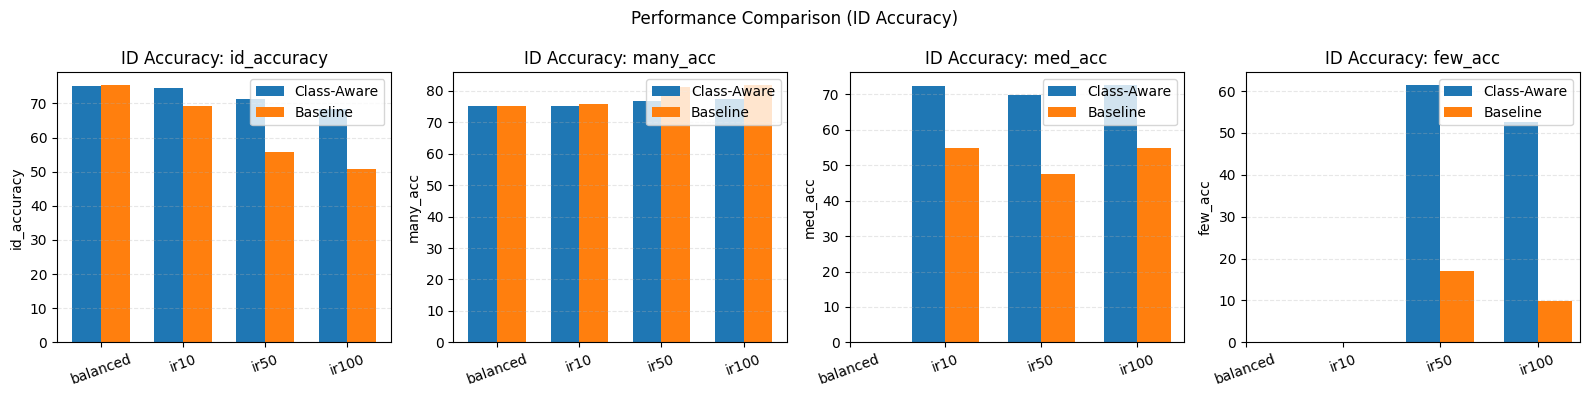

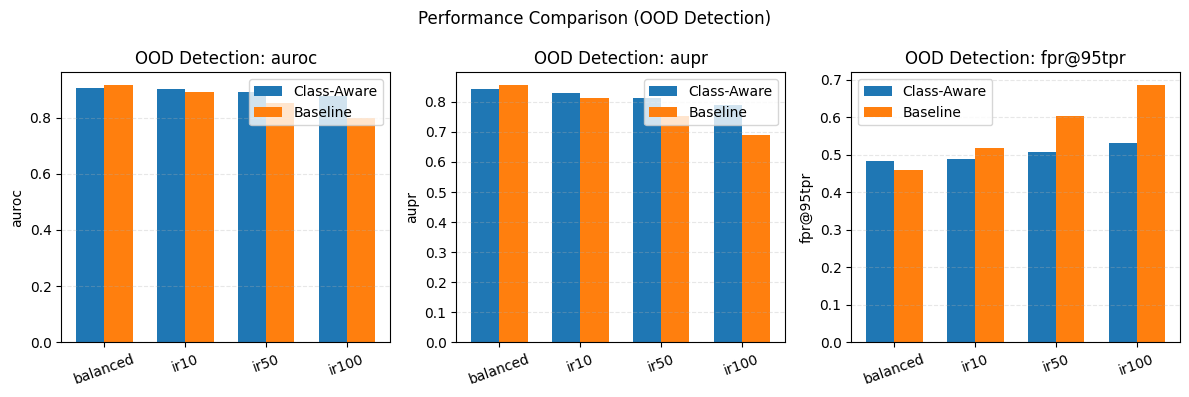

In [13]:
def safe_value(summary, key):
    value = summary.get(key) if summary else None
    if isinstance(value, (int, float, np.floating)):
        return float(value)
    return np.nan

metrics_groups = {
    "ID Accuracy": ["id_accuracy", "many_acc", "med_acc", "few_acc"],
    "OOD Detection": ["auroc", "aupr", "fpr@95tpr"],
}

scenario_names = list(summaries.keys())
methods = ["Class-Aware", "Baseline"]
bar_width = 0.35

for group_name, metric_keys in metrics_groups.items():
    fig, axes = plt.subplots(
        1,
        len(metric_keys),
        figsize=(4 * len(metric_keys), 4),
        sharey=False,
    )
    if len(metric_keys) == 1:
        axes = [axes]
    for ax, metric_key in zip(axes, metric_keys):
        positions = np.arange(len(scenario_names))
        for idx, method_name in enumerate(methods):
            values = [
                safe_value(summaries.get(scenario, {}).get(method_name, {}), metric_key)
                for scenario in scenario_names
            ]
            offset = (idx - (len(methods) - 1) / 2) * bar_width
            ax.bar(positions + offset, values, bar_width, label=method_name)
        ax.set_xticks(positions)
        ax.set_xticklabels(scenario_names, rotation=20)
        ax.set_title(f"{group_name}: {metric_key}")
        ax.grid(axis="y", linestyle="--", alpha=0.3)
        ax.set_ylabel(metric_key)
        ax.legend()
    fig.suptitle(f"Performance Comparison ({group_name})")
    plt.tight_layout()
    plt.show()

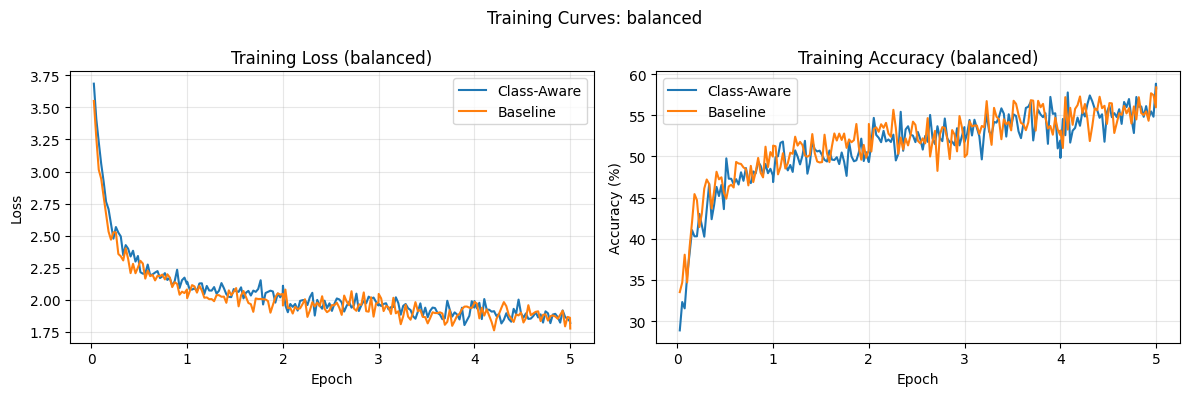

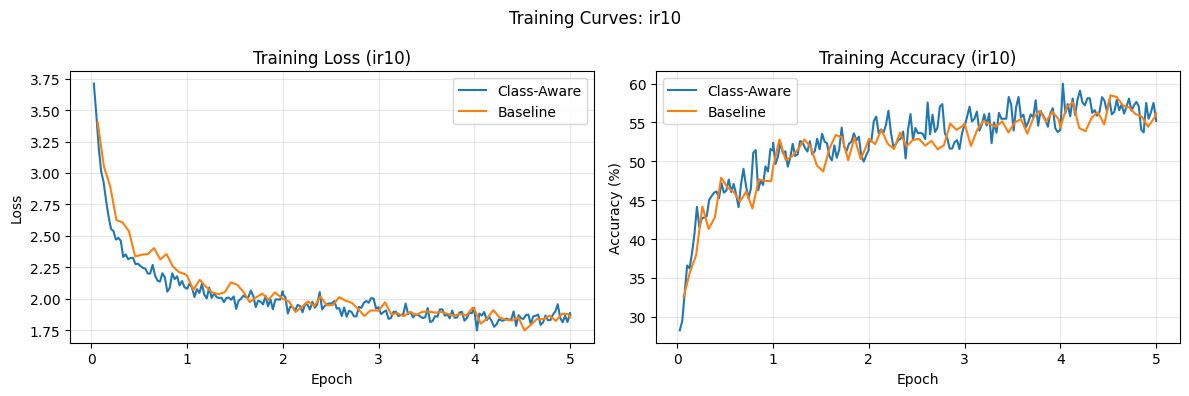

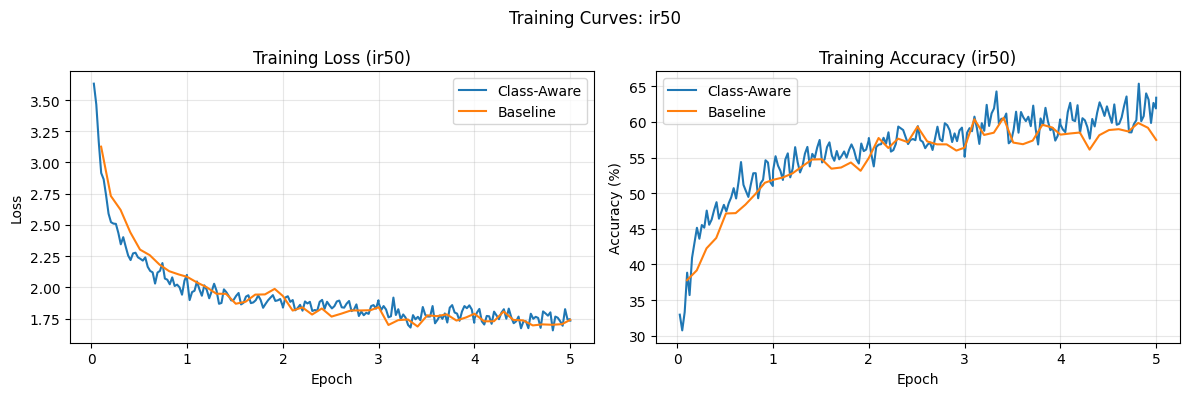

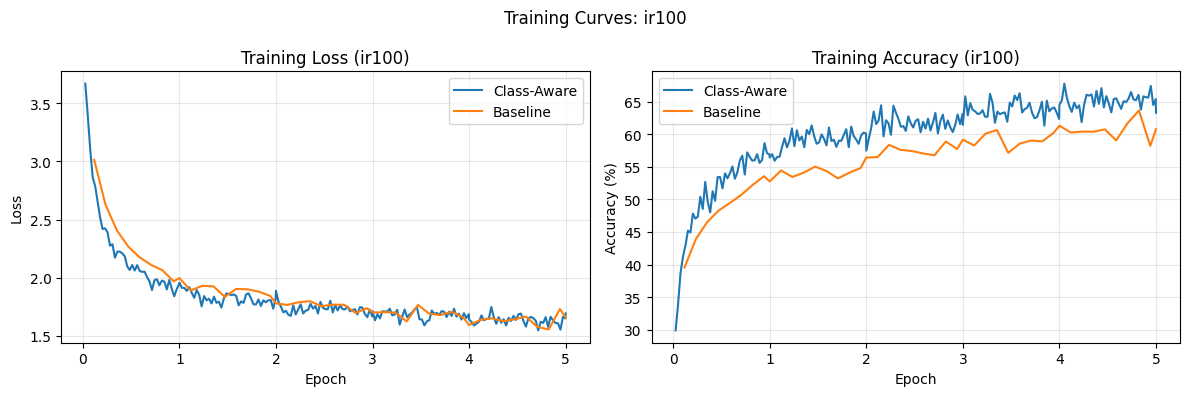

In [14]:
histories = {
    tag: {
        method_name: trainer.training_history
        for method_name, trainer in trainer_group.items()
    }
    for tag, trainer_group in trainers.items()
}

if not any(
    history
    for scenario_histories in histories.values()
    for history in scenario_histories.values()
):
    raise RuntimeError("Run training before plotting the training curves.")

def compute_epoch_positions(history):
    positions = []
    for entry in history:
        total = entry.get("total_batches", 1)
        total = total if total > 0 else 1
        frac = entry["batch"] / total
        positions.append(entry["epoch"] - 1 + frac)
    return np.array(positions, dtype=np.float32)

for tag, scenario_histories in histories.items():
    if not any(scenario_histories.values()):
        print(f"No training history available for {tag}; skipping plot.")
        continue
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    metric_specs = [
        ("Training Loss", "loss", "Loss"),
        ("Training Accuracy", "acc", "Accuracy (%)"),
    ]
    for ax, (title, key, ylabel) in zip(axes, metric_specs):
        for method_name, history in scenario_histories.items():
            if not history:
                continue
            steps = compute_epoch_positions(history)
            values = np.array([entry.get(key, np.nan) for entry in history], dtype=np.float32)
            ax.plot(steps, values, label=method_name)
        ax.set_title(f"{title} ({tag})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(ylabel)
        ax.grid(alpha=0.3)
        ax.legend()
    fig.suptitle(f"Training Curves: {tag}")
    plt.tight_layout()
    plt.show()

In [15]:
from sklearn.metrics import precision_recall_curve, auc

TARGET_SCENARIO = "balanced"
TARGET_METHOD = "Class-Aware"

target_trainer = trainers[TARGET_SCENARIO][TARGET_METHOD]

if target_trainer.last_ood_scores is None:
    raise RuntimeError(
        "Run evaluate_run() for the selected trainer before computing precision curves."
)

id_scores = np.asarray(target_trainer.last_ood_scores["id"], dtype=np.float32)
ood_scores = np.asarray(target_trainer.last_ood_scores["ood"], dtype=np.float32)
labels_id = np.concatenate([np.ones_like(id_scores), np.zeros_like(ood_scores)])
scores = np.concatenate([id_scores, ood_scores])

prec_id, rec_id, _ = precision_recall_curve(labels_id, scores)
aupr_id = auc(rec_id, prec_id)

labels_ood = 1 - labels_id
prec_ood, rec_ood, _ = precision_recall_curve(labels_ood, -scores)
aupr_ood = auc(rec_ood, prec_ood)

print(f"AUPR (ID positive): {aupr_id:.4f}")
print(f"AUPR (OOD positive): {aupr_ood:.4f}")

AUPR (ID positive): 0.8427
AUPR (OOD positive): 0.9571
